/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 157s 99ms/step - accuracy: 0.0684 - loss: 6.9696
Epoch 2/15
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 199s 97ms/step - accuracy: 0.1144 - loss: 6.1112
Epoch 3/15
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 205s 99ms/step - accuracy: 0.1453 - loss: 5.8680
Epoch 4/15
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 149s 98ms/step - accuracy: 0.1572 - loss: 5.6686
Epoch 5/15
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 149s 98ms/step - accuracy: 0.1625 - loss: 5.4749
Epoch 6/15
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 147s 97ms/step - accuracy: 0.1725 - loss: 5.2733
Epoch 7/15
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 149s 98ms/step - accuracy: 0.1852 - loss: 5.0837
Epoch 8/15
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 147s 97ms/step - accuracy: 0.1863 - loss: 4.9458
Epoch 9/15
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 148s 97ms/step - accuracy: 0.1977 - loss: 4.7654
Epoch 10/15
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 202s 97ms/step - accuracy: 0.2021 - loss: 4.6470
Epoch 11/15
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 200s 96ms/step - accuracy: 0.2074 - loss: 4.50

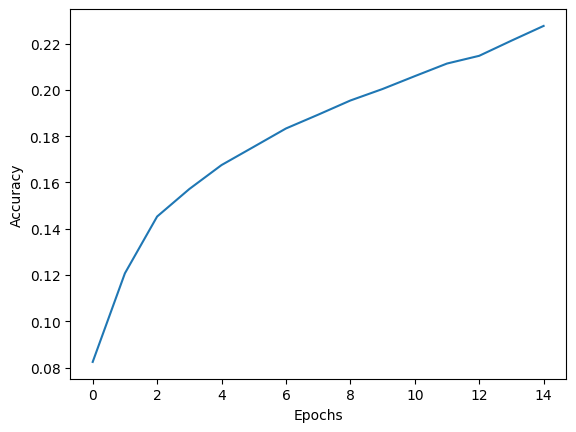

Artificial intelligence — the <OOV> of the


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load and preprocess data
medium_data = pd.read_csv('/content/medium_data.csv')
medium_data['title'] = medium_data['title'].astype(str).str.replace(u'\xa0', u' ').str.replace('\u200a', ' ')

# Tokenization with reduced vocabulary
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(medium_data['title'])
total_words = len(tokenizer.word_index) + 1

# Generate input sequences efficiently
input_sequences = []
for line in medium_data['title']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        input_sequences.append(token_list[:i+1])

max_sequence_len = max(map(len, input_sequences))
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

xs, labels = input_sequences[:, :-1], input_sequences[:, -1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

# Optimized model with correctly defined input shape
model = Sequential([
    Embedding(total_words, 64, input_length=max_sequence_len-1),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(100),
    Dense(total_words, activation='softmax')
])

# Compile & train the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
history = model.fit(xs, ys, epochs=15, verbose=1)

# Accuracy plot
plt.plot(history.history['accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

# Fixed text generation function
def generate_text(seed_text, next_words=5):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]

    for _ in range(next_words):
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

        # Ensuring correct shape input
        if token_list.shape[1] != max_sequence_len-1:
            print(f"Shape mismatch: {token_list.shape}, expected ({max_sequence_len-1},)")
            return seed_text

        predicted_probs = model.predict(token_list, verbose=0)
        predicted_index = np.argmax(predicted_probs[0])
        next_word = tokenizer.index_word.get(predicted_index, "<UNK>")

        seed_text += " " + next_word
        token_list = np.append(token_list[0], predicted_index)  # Append new word ID

    return seed_text

# Example text generation
print(generate_text("Artificial intelligence", 5))